# Training a second model

In this notebook, I train a second model using features in order to address the first model's shortcomings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.externals import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author,
    train_vectorizer, 
    get_vectorized_series,
    get_feature_vector_and_label
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)

from ml_editor.model_v2 import (
    add_char_count_features, 
    get_word_stats, 
    get_sentiment_score, 
    POS_NAMES,
    get_question_score_from_input
)
%load_ext autoreload
%autoreload 2
np.random.seed(35)

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df["is_question"]].copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/emmanuel.ameisen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")

Let's add new features we've identified as potential candidates in our new model.

In [3]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [4]:
vectorizer = train_vectorizer(train_df)
df["vectors"] = get_vectorized_series(df["full_text"].copy(), vectorizer)

Check out the ml_editor source code to see more about what these functions are doing!

In [5]:
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:16<00:00, 497.66it/s]


In [6]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

# Model

Now that we've added new features, let's train a new model. We'll use the same model as before, only the features are different.

In [7]:
# We split again since we have now added all features. 
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [8]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [9]:
y_train.value_counts()

False    3483
True     2959
Name: Score, dtype: int64

In [10]:
X_test.shape

(1529, 7799)

In [11]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

Now, we can measure performance as we saw in the first training notebook.

In [12]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1



# Training accuracy
# Thanks to https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Training accuracy = 0.588, precision = 0.564, recall = 0.457, f1 = 0.505


In [13]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Validation accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Validation accuracy = 0.610, precision = 0.628, recall = 0.497, f1 = 0.555


Fortunately, this model shows stronger aggregate performance than our previous model! Let's save our new model and vectorizer to disk so we can use them later.

In [14]:
model_path = Path("../models/model_2.pkl")
vectorizer_path = Path("../models/vectorizer_2.pkl")
joblib.dump(clf, model_path) 
joblib.dump(vectorizer, vectorizer_path) 

['../models/vectorizer_2.pkl']

## Validating that features are useful

Next, we'll use the method described in the feature importance [notebook](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/feature_importance.ipynb) to validate that our new features are being used by the new model.

In [15]:
w_indices = vectorizer.get_feature_names()
w_indices.extend(feature_arr)
all_feature_names = np.array(w_indices)

In [16]:
k = 20
print("Top %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\nBottom %s importances:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

Top 20 importances:

num_chars: 0.0082
num_diff_words: 0.008
num_periods: 0.0076
ADJ: 0.0075
num_questions: 0.0073
ADV: 0.0071
PUNCT: 0.0065
VERB: 0.0065
num_words: 0.0064
NOUN: 0.0064
DET: 0.0064
num_commas: 0.0064
ADP: 0.0062
PART: 0.0059
avg_word_len: 0.0057
polarity: 0.0056
num_stops: 0.0055
PRON: 0.0053
are: 0.0049
what: 0.0047

Bottom 20 importances:

fed: 0
counted: 0
mug: 0
returning: 0
multilingual: 0
temper: 0
growled: 0
terrified: 0
temple: 0
resulted: 0
resting: 0
murderer: 0
terminal: 0
favored: 0
cows: 0
growth: 0
crack: 0
cracks: 0
crap: 0
imho: 0


Our new features are amongst the most predictive! On the flip side, we can see that the word vectors from the TF-IDF vectorization approach don't seem to be particularly helpful. In a following [notebook](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/third_model.ipynb), we will train a third model without these features and see how well it performs.

## Comparing predictions to data

This section uses the evaluation methods described in the Comparing Data To Predictions [notebook](https://github.com/hundredblocks/ml-powered-applications/blob/master/notebooks/comparing_data_to_predictions.ipynb), but on our new model.

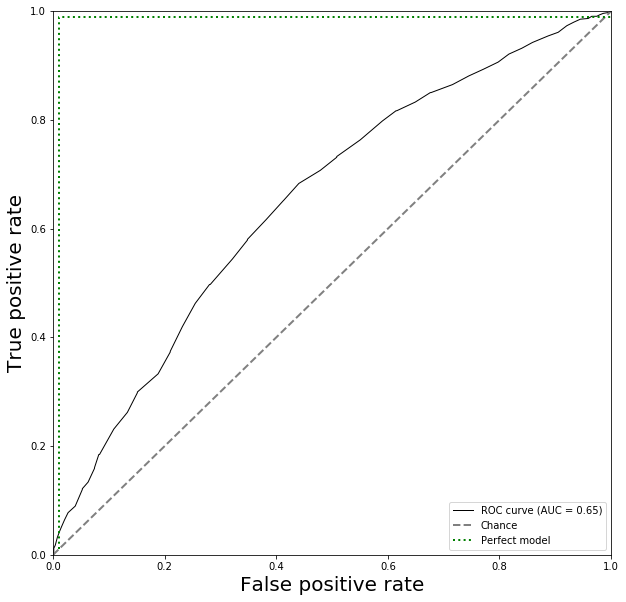

In [17]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

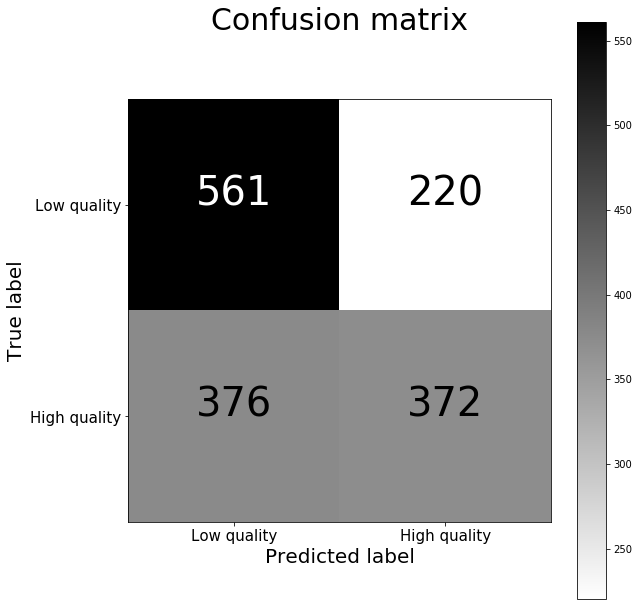

In [18]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No handles with labels found to put in legend.


	Brier: 0.234


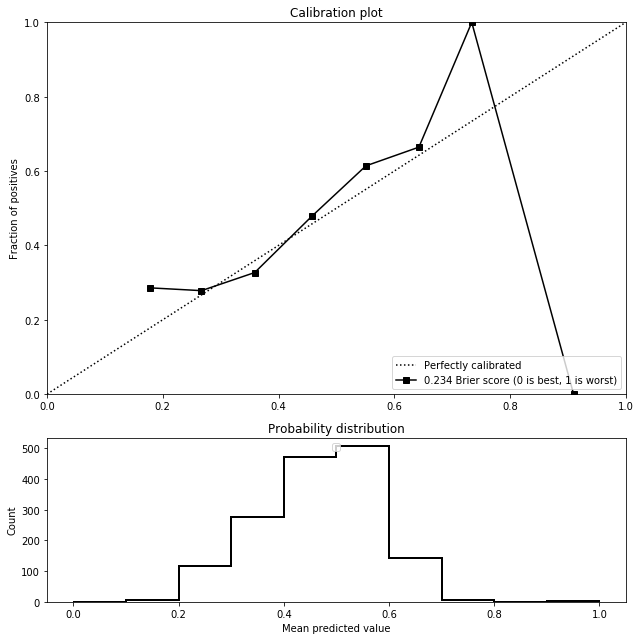

In [19]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

## Inference Function

Just like for our first model, we define an inference function that takes in an arbitrary question and outputs an estimated probability of it receiving a high score according to our model.

In [20]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████| 1/1 [00:00<00:00, 978.38it/s]

0.36 probability of the question receiving a high score according to our model
